In [1]:
%%capture --no-stderr
%pip install -q -U langgraph langchain-google-genai langgraph-sdk

In [2]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

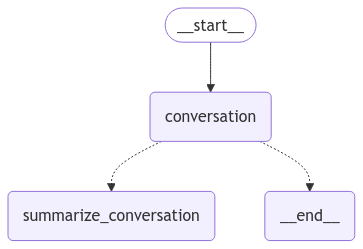

In [3]:
from IPython.display import Image, display
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph
from typing import Literal
from langgraph.types import Command

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

class State(MessagesState):
    summary: str


def call_model(state: State, config: RunnableConfig) -> Command[Literal["summarize_conversation", END]]:
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages, config)

    goto = "summarize_conversation" if len(state["messages"]) > 6 else END

    return Command(
        update={"messages": response},
        goto=goto
    )


def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return Command(
        update={"summary": response.content, "messages": delete_messages},
        goto=END
    )


workflow: StateGraph = StateGraph(State)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [HumanMessage(content="Hello")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cd8ea894-4a09-4f67-b726-365b2131750f-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})}}


In [5]:
for chunk in graph.stream({"messages": [HumanMessage(content="Hello!")]}, config, stream_mode="updates"):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

Hello to you too!  How can I assist you?


In [6]:
for event in graph.stream({"messages": [HumanMessage(content="Hi")]}, config, stream_mode="values"):
    # for m in event["messages"]:
    #     m.pretty_print()
    # print("---"*25)
    print(event)

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='dc7f051b-8ebe-4009-9ecb-051ee81612fe'), AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cd8ea894-4a09-4f67-b726-365b2131750f-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='b9008de9-6a62-4edb-a58f-89ce8bf2493f'), AIMessage(content='Hello to you too!  How can I assist you?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-dc8502f2-8405-41df-ad87-3849223a06c5-0', usage_metadata={'input_tokens': 13, 'output_tokens': 13, 'total_tokens': 26, 'input_token_details': {'cache

In [7]:
config = {"configurable": {"thread_id": "2"}}

for event in graph.stream({"messages": [HumanMessage(content="Hi")]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hi
---------------------------------------------------------------------------
================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hi there! How can I help you today?
---------------------------------------------------------------------------


In [8]:
config = {"configurable": {"thread_id": "3"}}

input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"NODE: {event['metadata'].get('langgraph_node','')}. TYPE: {event['event']}. NAME: {event['name']}")

NODE: . TYPE: on_chain_start. NAME: LangGraph
NODE: __start__. TYPE: on_chain_start. NAME: __start__
NODE: __start__. TYPE: on_chain_start. NAME: _write
NODE: __start__. TYPE: on_chain_end. NAME: _write
NODE: __start__. TYPE: on_chain_start. NAME: _write
NODE: __start__. TYPE: on_chain_end. NAME: _write
NODE: __start__. TYPE: on_chain_stream. NAME: __start__
NODE: __start__. TYPE: on_chain_end. NAME: __start__
NODE: conversation. TYPE: on_chain_start. NAME: conversation
NODE: conversation. TYPE: on_chat_model_start. NAME: ChatGoogleGenerativeAI
NODE: conversation. TYPE: on_chat_model_stream. NAME: ChatGoogleGenerativeAI
NODE: conversation. TYPE: on_chat_model_stream. NAME: ChatGoogleGenerativeAI
NODE: conversation. TYPE: on_chat_model_stream. NAME: ChatGoogleGenerativeAI
NODE: conversation. TYPE: on_chat_model_stream. NAME: ChatGoogleGenerativeAI
NODE: conversation. TYPE: on_chat_model_stream. NAME: ChatGoogleGenerativeAI
NODE: conversation. TYPE: on_chat_model_stream. NAME: ChatGoogle